In [ ]:
#Step 1 - Import libraries
import matplotlib.pyplot as plt, numpy as np, os, shutil, cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
#Step2 - Loading the dataset
#Download and unzip dataset
!kaggle datasets download -d rajat95gupta/smartphone-image-denoising-dataset
!unzip smartphone-image-denoising-dataset.zip -d ./sidd

Dataset URL: https://www.kaggle.com/datasets/rajat95gupta/smartphone-image-denoising-dataset
License(s): other
100% 6.16G/6.16G [02:46<00:00, 40.4MB/s]
100% 6.16G/6.16G [02:46<00:00, 39.7MB/s]
Archive:  smartphone-image-denoising-dataset.zip
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/GT_SRGB_010.PNG  
  inflating: ./sidd/SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/NOISY_S

In [ ]:
# Step 3 - Prepare the dataset for denoising and colorization
data_dir = '/content/sidd/SIDD_Small_sRGB_Only/Data'
scene_dirs = os.listdir(data_dir)  # List of files and subfolders in the Data directory
print(f"Number of directories: {len(scene_dirs)}")

# Lists to store image paths
noisy_images = []
original_images = []

# Gaussian noise parameters
gaussian_mean = 0  # Mean of the Gaussian noise
gaussian_stddev = 0.1  # Standard deviation of the Gaussian noise

# Iterate through subfolders and prepare the data
for scene in tqdm(scene_dirs):
    scene_path = os.path.join(data_dir, scene)
    files = os.listdir(scene_path)

    # Identify the noisy files and GT files
    noisy_file = next((f for f in files if "NOISY_SRGB" in f.upper() and f.endswith('.PNG')), None)
    gt_file = next((f for f in files if "GT_SRGB" in f.upper() and f.endswith('.PNG')), None)

    # Check if both files exist
    if noisy_file and gt_file:
        # Full paths of the files
        noisy_src = os.path.join(scene_path, noisy_file)
        gt_src = os.path.join(scene_path, gt_file)

        # Load and resize the noisy image (NOISY) to 256x256 and add it to the list
        noisy_img = cv2.imread(noisy_src)
        noisy_img_resized = cv2.resize(noisy_img, (256, 256)) / 255.0  # Normalize between 0 and 1

        # Add Gaussian noise to the noisy image
        gaussian_noise = np.random.normal(gaussian_mean, gaussian_stddev, noisy_img_resized.shape)
        noisy_img_gaussian = np.clip(noisy_img_resized + gaussian_noise, 0, 1)  # Clip to [0, 1]
        noisy_images.append(noisy_img_gaussian)

        # Load and resize the original GT image to 256x256 and add it to the list
        original_img = cv2.imread(gt_src)
        original_img_resized = cv2.resize(original_img, (256, 256)) / 255.0  # Normalize between 0 and 1
        original_images.append(original_img_resized)

    else:
        print(f"Missing files in {scene_path}")
        continue

# Convert the lists to numpy arrays
noisy = np.array(noisy_images)  # Noisy images with added Gaussian noise
original = np.array(original_images)  # Original images

# Check the shapes of the arrays
print(f"Shape of noisy: {noisy.shape}")
print(f"Shape of original: {original.shape}")

# --- Split for denoising task (noisy vs original) ---
# 80% training, 20% temp
noisy_train, noisy_temp, original_train, original_temp = train_test_split(
    noisy, original, test_size=0.2, random_state=42
)

# Split temp into 10% validation, 10% test
noisy_val, noisy_test, original_val, original_test = train_test_split(
    noisy_temp, original_temp, test_size=0.5, random_state=42
)

# Check the shapes of the datasets for denoising
print("\nDenoising Task:")
print(f"Shape of noisy_train: {noisy_train.shape}")
print(f"Shape of original_train: {original_train.shape}")
print(f"Shape of noisy_val: {noisy_val.shape}")
print(f"Shape of original_val: {original_val.shape}")
print(f"Shape of noisy_test: {noisy_test.shape}")
print(f"Shape of original_test: {original_test.shape}")



Number of directories: 160


100%|██████████| 160/160 [02:45<00:00,  1.04s/it]


Shape of noisy: (160, 256, 256, 3)
Shape of original: (160, 256, 256, 3)
Shape of gray: (160, 256, 256, 1)

Denoising Task:
Shape of noisy_train: (128, 256, 256, 3)
Shape of original_train: (128, 256, 256, 3)
Shape of noisy_val: (16, 256, 256, 3)
Shape of original_val: (16, 256, 256, 3)
Shape of noisy_test: (16, 256, 256, 3)
Shape of original_test: (16, 256, 256, 3)

Colorization Task:
Shape of gray_train: (128, 256, 256, 1)
Shape of original_train_color: (128, 256, 256, 3)
Shape of gray_val: (16, 256, 256, 1)
Shape of original_val_color: (16, 256, 256, 3)
Shape of gray_test: (16, 256, 256, 1)
Shape of original_test_color: (16, 256, 256, 3)


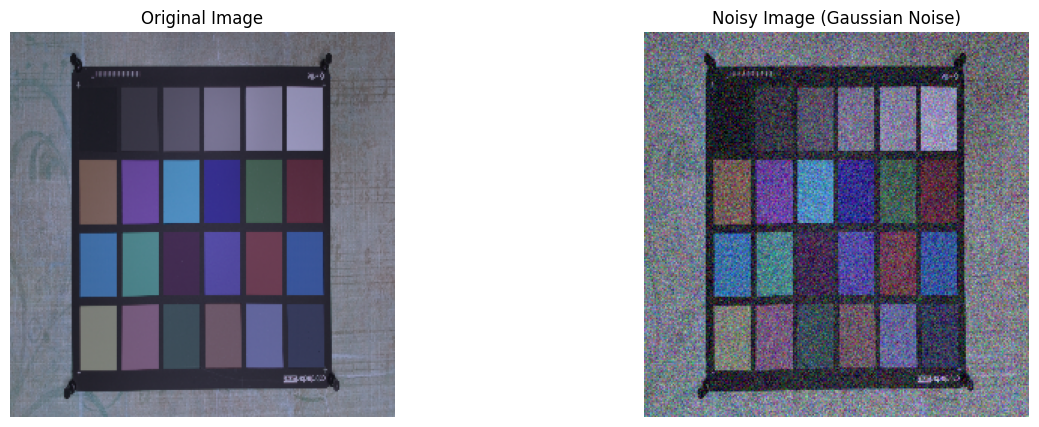

In [ ]:
# Visualization of Original and Noisy Images

# Choose an image from the dataset for comparison
index = 0  # Select the index of the image to display (here, the first image)

# Retrieve the corresponding images
original_image = original_images[index]  # Original image
noisy_image = noisy_images[index]  # Noisy image (from the dataset)
noisy_image_gaussian = noisy[index]  # Noisy image with added Gaussian noise

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the images
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Disable axes

axes[1].imshow(noisy_image_gaussian)
axes[1].set_title("Noisy Image (Gaussian Noise)")
axes[1].axis('off')

# Show the plot
plt.show()


In [ ]:
##DENOISING
# Step 4 - Create a CNN model for image denoising
def create_denoising_cnn(input_shape):
    model = models.Sequential() # The model is sequential, which means that the layers will be added one after the other in a linear order.

    # First convolution layer + ReLU activation
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Activation('relu'))

    # Second convolution layer + ReLU activation
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))

    # Third convolution layer + ReLU activation
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))

    # Convolution layer to produce a denoised image
    model.add(layers.Conv2D(3, (3, 3), padding='same'))  # Three channels for a color image
    model.add(layers.Activation('sigmoid'))  # Activation to produce values between 0 and 1

    # Model compilation
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define input shape (height, width, 3 channels for an RGB image)
input_shape = (256, 256, 3)

# Create the model
denoising_model = create_denoising_cnn(input_shape)

# Model summary
denoising_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256, 256, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 3)         │           6,915 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,731 (1.44 MB)

 Trainable params: 377,731 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5 - Train the model with the denoising data
denoising_model.fit(
    noisy_train,  # Noisy images (noisy_train)
    original_train,  # Original images (original_train)
    epochs=20,  # The model will go through the entire dataset 20 times.
    batch_size=8,  # The model will process 8 images at a time before adjusting the weights.
    validation_data=(noisy_val, original_val)  # Use separate validation data
)

# Save the model after training
denoising_model.save('denoising_cnn_model.h5')


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 540s 34s/step - accuracy: 0.7298 - loss: 0.0747 - val_accuracy: 0.8576 - val_loss: 0.0072
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 548s 33s/step - accuracy: 0.7898 - loss: 0.0162 - val_accuracy: 0.8575 - val_loss: 0.0045
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 573s 34s/step - accuracy: 0.7543 - loss: 0.0122 - val_accuracy: 0.5607 - val_loss: 0.0031
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 553s 33s/step - accuracy: 0.7246 - loss: 0.0072 - val_accuracy: 0.8861 - val_loss: 0.0047
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 568s 33s/step - accuracy: 0.7797 - loss: 0.0051 - val_accuracy: 0.8666 - val_loss: 0.0023
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 560s 33s/step - accuracy: 0.8155 - loss: 0.0036 - val_accuracy: 0.8928 - val_loss: 0.0019
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 550s 33s/step - accuracy: 0.8360 - loss: 0.0028 - val_accuracy: 0.9034 - val_loss: 0.0041
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 564s 33s/step - accuracy: 0.8365 - loss: 0.0044 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Average PSNR: 27.79
Average MSE: 0.0020


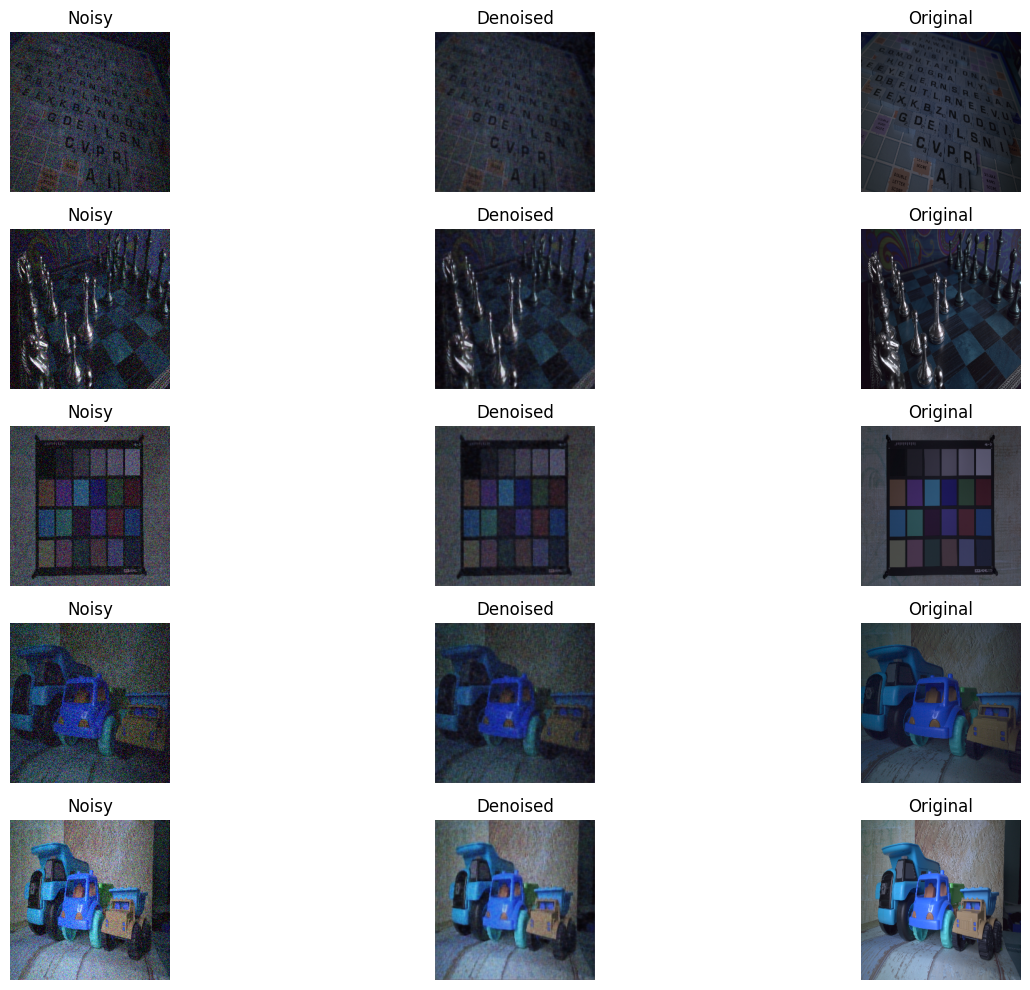

In [ ]:
# Step 6 - Evaluate the Model and Display Results

# Load the saved model
model = tf.keras.models.load_model("/content/denoising_cnn_model.h5")

# Check normalization (data should be between 0 and 1)
noisy_test = noisy_test.astype("float32") / 255.0 if noisy_test.max() > 1 else noisy_test
original_test = original_test.astype("float32") / 255.0 if original_test.max() > 1 else original_test

# Predict the denoised images
denoised_images = model.predict(noisy_test)

# Function to evaluate PSNR and MSE metrics
def evaluate_metrics(ground_truth, predictions):
    psnr_values = []
    mse_values = []
    for gt, pred in zip(ground_truth, predictions):
        # Convert images to grayscale if they are RGB
        if gt.shape[-1] == 3:  # RGB images
            gt = tf.image.rgb_to_grayscale(gt).numpy().squeeze()
            pred = tf.image.rgb_to_grayscale(pred).numpy().squeeze()

        # Calculate PSNR
        psnr_value = psnr(gt, pred, data_range=1.0)
        psnr_values.append(psnr_value)

        # Calculate MSE
        mse_value = np.mean((gt - pred) ** 2)
        mse_values.append(mse_value)

    return np.mean(psnr_values), np.mean(mse_values)

# Calculate the metrics on the test set
mean_psnr, mean_mse = evaluate_metrics(original_test, denoised_images)
print(f"Average PSNR: {mean_psnr:.2f}")
print(f"Average MSE: {mean_mse:.4f}")

# Display the results (noisy, denoised, and original images)
def display_results(noisy, denoised, original, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(noisy[i], cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(denoised[i], cmap="gray")
        plt.title("Denoised")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(original[i], cmap="gray")
        plt.title("Original")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display some results
display_results(noisy_test, denoised_images, original_test)
